In [17]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

weather = pd.read_csv('data/weather.csv', parse_dates=['Date'])

from util import ks, tvd

# Identifying Mechanisms of Missing Data
---

## Assessing ignorable vs. non-ignorable missing data

Distinguishing ignorable missing data from non-ignorable missing data involves reasoning about the data generating process, using domain expertise. The data scientist must make an *assumption* of whether the missingness of the data is explainable from the observed data itself.

*Remark:* One tactic for reduce the severity of non-ignorable effects of missing data are to include as many attributes in the dataset as possible ('the kitchen sink') in hopes that the many attributes will likely explain the missingness. This reduces the usability of the dataset and even so, one can never cover all possible attributes. Careful reasoning with knowledge of the domain is the *only* way to reason about the nature of missing data.

**Example:** Suppose, every day of the year, a park ranger drives up a mountain at sunrise and measures the wind-speed. At the end of the year, the ranger has a dataset of observed wind-speeds.
* Any missing data is likely *non-ignorable*. It's more difficult to drive up the mountain in bad weather, which is correlated with high winds. Thus, the likelihood an observation is missing depends on the value itself.
* Adding a date-of-measurement column to each observation would partially explain the missing observations, as bad weather is more likely to occur in the winter months. However, this would only reduce the effect of non-ignorability, as the date-of-measurement would not explain when a value is likely to be missing within the winter months.

**Example:** Now suppose the same park ranger doesn't make measurements on Wednesdays, as he doesn't work then; he successfully makes measurements *every other* day. At the end of the year, the ranger has a (one-column) dataset of observed wind-speeds. This attribute is likely missing completely at random, as the weather knows nothing about the day of the week.

*Remark:* One column datasets necessarily have either non-ignorable missing data or data that are missing completely at random.

## Assessing types of ignorable missing data

Once a dataset is assumed to contain only ignorable missing data (i.e. that it's 'missing at random'), one needs to determine exactly what this missingness looks like:
* For each attribute, which columns affect the likelihood of missingness of that attribute? 
* In what ways is the missingness conditional on those columns?

These questions are neatly answered by comparing two distributions: for a given attribute, compare the distributions when an attribute is missing vs when the attribute is observed. If those distributions are similar, and the missingness is explainable by the (rest of the) observed data, then the observed data is a representative sample of the 'true model'.

**Example:** Suppose, as outlined above, a park ranger measures the wind every day for a year. The table includes not only the date and wind-measurement, but also nearby temperature readings at the ranger station.

Assuming ignorable missing data, explain exactly *how* the missingness of the wind-speed measurements depend on the other attributes in the dataset.

In [6]:
weather.head()

,Date,Temp,Wind
0,2015-01-01,29.23,6.54
1,2015-01-02,22.05,18.24
2,2015-01-03,23.31,20.38
3,2015-01-04,20.75,43.29
4,2015-01-05,28.82,42.83


Approximately 10% of the measurements in the table are missing:

In [5]:
weather['Wind'].isnull().mean()

0.10164835164835165

**To start the analysis, check that the likelihood wind-speed is missing does depend on the day of the week.**

In [8]:
# add day of the week
weather['day_name'] = weather['Date'].dt.day_name()
weather.head()

,Date,Temp,Wind,day_name
0,2015-01-01,29.23,6.54,Thursday
1,2015-01-02,22.05,18.24,Friday
2,2015-01-03,23.31,20.38,Saturday
3,2015-01-04,20.75,43.29,Sunday
4,2015-01-05,28.82,42.83,Monday


To assess the dependency of the missingness of wind-measurements on the day of the week, compare:
1. the distribution of day of the week, when the wind measurement is missing,
1. the distribution of day of the week, when the wind measurement is not missing.

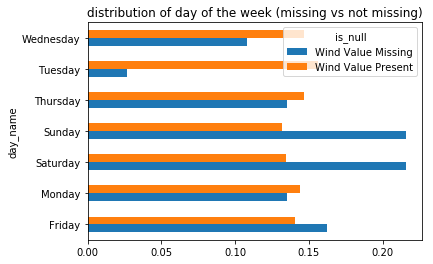

In [12]:
is_null = (
    weather['Wind']
    .isnull()
    .replace({True: 'Wind Value Missing', False: 'Wind Value Present'})
)

distrs = (
    weather
    .assign(is_null=is_null)
    .pivot_table(index='day_name', columns='is_null', aggfunc='size')
    .apply(lambda x:x/x.sum())
)

distrs.plot(kind='barh', title='distribution of day of the week (missing vs not missing)');

Are these two distributions similar? Is the dissimilarity between the two explainable as noise? It's far from clear. A few observations might clarify issues at play:
* The distribution of days of the week among the non-missing values are roughly equally likely,
* There are a small number of missing values for each day of the week (roughly 5-10).

This question can be answered quantitatively with a permutation test, using the total variation distance.

The observed difference between the two distributions above are:

In [14]:
obs_tvd = tvd(weather['day_name'], weather['Wind'].isnull())
obs_tvd

0.18786676584841724

Here, the `tvd` function is taken from the code in the 'Permutation Tests' section of the previous chapter.

A permutation test on this data returns:

In [15]:
tvds = []
for _ in range(1000):
    
    shuffed_tvd = tvd(
        weather['day_name'].sample(frac=1.0).reset_index(drop=True),
        weather['Wind'].isnull()
    )
    
    tvds.append(shuffed_tvd)

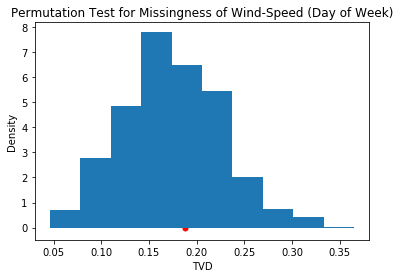

In [22]:
pd.Series(tvds).plot(kind='hist', title='Permutation Test for Missingness of Wind-Speed (Day of Week)', density=True)
plt.xlabel('TVD')
plt.ylabel('Density')
plt.scatter([obs_tvd], [0], c='r', s=25);

The observed TVD seems likely to have been generated from the null hypothesis, and so fail to reject it. The p-value confirms this:

In [24]:
(pd.Series(tvds) >= obs_tvd).mean()

0.336

Thus, there is no evidence that the missingness of 'Wind' depends on the day of the week the measurement was taken.

**Does the likelihood that the 'Wind' column is missing depend on the temperature that day?**

Plotting the distribution of temperatures when 'Wind' is missing versus not-missing:

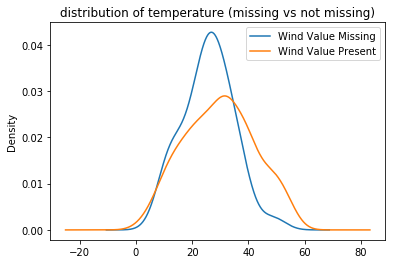

In [27]:
(
    weather
    .assign(is_null=is_null)
    .groupby('is_null')['Temp']
    .plot(kind='kde', legend=True, title='distribution of temperature (missing vs not missing)')
);

It certainly seems as though the wind-speed measurements are more likely missing when temperatures are lower. However, a permutation test will quantitatively assess this claim. Since the distributions in this example are quantitative, the KS-statistic is appropriate:

The observed KS-statistic is given by:

In [28]:
obs_ks = ks(weather['Temp'], weather['Wind'].isnull())
obs_ks

0.2516736920406629

Here, the `ks` function is taken from the code in the 'Permutation Tests' section of the previous chapter.

To assess if this value is small or large, a the null hypothesis of a permutation test will generate reasonable values for the test-statistic, using a significance level of 0.05.

In [30]:
kss = []
for _ in range(1000):
    
    shuffed_ks = ks(
        weather['Temp'].sample(frac=1.0).reset_index(drop=True),
        weather['Wind'].isnull()
    )
    
    kss.append(shuffed_ks)

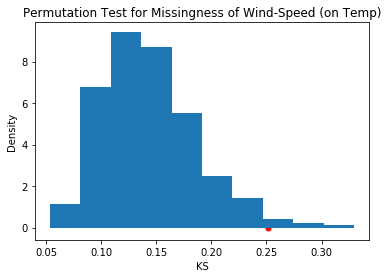

In [32]:
pd.Series(out).plot(kind='hist', density=True, title='Permutation Test for Missingness of Wind-Speed (on Temp)')
plt.xlabel('KS')
plt.ylabel('Density')
plt.scatter([obs_ks], [0], c='r', s=25);

The observed KS is not likely seen under the null hypothesis, as the p-value shows:

In [33]:
(pd.Series(kss) >= obs_ks).mean()

0.017

Thus, the missingness of wind-speed *does* likely depend on the temperature readings for that day. 'Wind' is ignorable, or missing at random, dependend on 'Temp'.

*Remark:* What other variables might influence the missingness of 'Wind'? For example, what about the month of the year?

**A note on the assumption of ignorability**

Before starting this example, an assumption was made that the missingness of 'Wind' was ignorable. Given that, it was concluded that the missingness of 'Wind' was dependent on the temperature at the time. However is ignorability a reasonable assumption to make?

As was observed at the beginning of the section, a priori, the missingness of wind measurements are likely non-ignorable. For example, high winds on a given day may:
* make it harder to travel to the spot where the wind readings are taken,
* cause other emergencies that require attending to, making it less likely to find time to make the readings.

However, in observing that 'severe conditions' in the mountains are also associated with low temperature, adding temperature measurements might *dampen* (not eliminate) some of this non-ignorability. To further reduce the effect, one might search for other attributes that associate with possible non-ignorable effects (like precipitation).

## A procedure for distinguishing types of ignorable missing data

Once missing data are assumed to be ignorable (i.e. explainable by the observed data), one still needs to understand *how* the missing attributes may depend on the observed data. That is, for each attribute, one needs to determine how the missingness of that attribute depends on other observed attributes. If the missingness of each attribute is independent of every other observed attribute, then the missing data is *unconditionally ignorable* or *missing completely at random* -- that is, the likelihood an observation is missing is well-modeled by a (biased) coin flip.

### The algorithm

Suppose the data collected in columns $C_I$ are assumed be ignorable.

```
dep_cols = {c:[] for c in C_I}

For each attribute c in C_I:
    For each attribute c' not equal to c:
        Let D_mis(c') be the distribution of c' conditional on c=missing
        Let D_obs(c') be the distribution of c' conditional on c=not missing
        Determine if D_mis(c') ~ D_obs(c') (using permutation test)
        if D_mis(c') ~ D_obs(c'):
            D[c] = D[c] + [c']
        else:
            pass

```

This algorithm produces, for each ignorable attribute, a list of columns for which the missingness of the attribute depends. If the list of a given column is empty, then it's unconditionally ignorable (i.e. missing completely at random).

*Remark:* The algorithm doesn't reveal *how* the missingness of a column may depend on the observed data. Such observations are very useful, but rely on analyzing the similarity of the two distributions more closely.